In [ ]:
%cd "/content/drive/MyDrive/Aiml project new/archive/New folder"

/content/drive/.shortcut-targets-by-id/1-G1qGv1Q6cdjawRS6KxH-kn0wzOmry0U/Aiml project new/archive/New folder


In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image, ImageFilter
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy import ndimage
from prettytable import PrettyTable
import joblib
import time
import warnings
warnings.filterwarnings('ignore')

## Load and Merge Data

In [ ]:
# Load CSV data
df = pd.read_csv('cleaned_metadata_with_image_paths.csv')
print(f"CSV data shape: {df.shape}")

CSV data shape: (4033, 8)


In [ ]:
# CSV Data preprocessing
df_clean = df.copy()
df_clean = df_clean.dropna(subset=['dx'])

# Encode categorical variables for metadata
categorical_features = ['sex', 'localization', 'dx_type']
numeric_features = ['age']

# Create preprocessing for metadata
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ])

In [ ]:
IMAGE_SIZE = (128, 128)
DATA_PATH = "categorized_images"

### Image preprocessing and data extraction

In [ ]:
# Image loading and preprocessing
def load_and_preprocess_image(image_path, size=(128, 128)):
    img = Image.open(image_path)

    # Convert to color spaces
    img_rgb = img.convert('RGB').resize(size)
    img_gray = img.convert('L').resize(size)
    img_hsv = img.convert('HSV').resize(size)

    # Convert to numpy arrays
    return np.array(img_rgb), np.array(img_gray), np.array(img_hsv)

In [ ]:
# Color feature extraction (RGB + HSV)
def extract_color_features(rgb_array, hsv_array):
    features = {}

    # RGB statistics
    for i, channel in enumerate(['R', 'G', 'B']):
        data = rgb_array[:, :, i]
        features[f'{channel}_mean'] = np.mean(data)
        features[f'{channel}_std'] = np.std(data)
        features[f'{channel}_median'] = np.median(data)
        features[f'{channel}_range'] = np.ptp(data)

    # HSV statistics
    for i, channel in enumerate(['H', 'S', 'V']):
        data = hsv_array[:, :, i]
        features[f'{channel}_mean'] = np.mean(data)
        features[f'{channel}_std'] = np.std(data)

    return features

In [ ]:
# Texture feature extraction
def local_binary_pattern(image, radius=1):
    padded = np.pad(image, radius, mode='edge')
    patterns = []
    for i in range(radius, padded.shape[0]-radius):
        for j in range(radius, padded.shape[1]-radius):
            neighborhood = padded[i-radius:i+radius+1, j-radius:j+radius+1]
            center_val = image[i-radius, j-radius]
            pattern = (neighborhood > center_val).astype(int)
            patterns.append(np.sum(pattern))
    return np.array(patterns)

In [ ]:
# Edge detection
def extract_edge_features(gray_array):
    sobel_x = ndimage.sobel(gray_array, axis=0)
    sobel_y = ndimage.sobel(gray_array, axis=1)
    gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)

    return {
        'edge_density': np.mean(gradient_magnitude > 30),
        'edge_strength_mean': np.mean(gradient_magnitude),
        'edge_strength_std': np.std(gradient_magnitude)
    }

In [ ]:
def extract_texture_features(gray_array):
    lbp_features = local_binary_pattern(gray_array)
    hist, _ = np.histogram(lbp_features, bins=10)
    entropy = -np.sum(hist * np.log2(hist + 1e-8))

    return {
        'texture_mean': np.mean(lbp_features),
        'texture_std': np.std(lbp_features),
        'texture_entropy': entropy
    }

In [ ]:
# Asymmetric calculation
def calculate_asymmetry(image):
    h, w = image.shape
    left_half = image[:, :w//2]
    right_half = np.fliplr(image[:, w//2:])

    # Crop to same shape
    min_h = min(left_half.shape[0], right_half.shape[0])
    min_w = min(left_half.shape[1], right_half.shape[1])

    diff = np.abs(left_half[:min_h, :min_w] - right_half[:min_h, :min_w])
    return {'asymmetry': np.mean(diff)}

In [ ]:
# Local color homogamy
def extract_color_homogeneity(rgb_array):
    from scipy import ndimage
    features = {}
    for i, channel in enumerate(['R', 'G', 'B']):
        data = rgb_array[:, :, i]
        local_var = ndimage.gaussian_filter(data, sigma=1) - ndimage.gaussian_filter(data, sigma=3)
        features[f'{channel}_color_variation'] = np.std(local_var)
    return features

In [ ]:
# Compact color histograms
def extract_histogram_features(rgb_array):
    features = {}
    for i, channel in enumerate(['R', 'G', 'B']):
        data = rgb_array[:, :, i]
        hist, _ = np.histogram(data, bins=16, density=True)
        s = pd.Series(hist)
        features[f'{channel}_hist_mean'] = np.mean(hist)
        features[f'{channel}_hist_std'] = np.std(hist)
        features[f'{channel}_hist_skew'] = s.skew()
    return features

In [ ]:
# Extract the features
def extract_image_features(image_path):
    try:
        rgb_array, gray_array, hsv_array = load_and_preprocess_image(image_path)

        features = {}
        features.update(extract_color_features(rgb_array, hsv_array))
        features.update(extract_texture_features(gray_array))
        features.update(extract_edge_features(gray_array))
        features.update(calculate_asymmetry(gray_array))
        features.update(extract_color_homogeneity(rgb_array))
        features.update(extract_histogram_features(rgb_array))

        # Final vector
        vector = np.array([features[k] for k in sorted(features.keys())])
        return vector

    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

### Prepare the dataset

In [ ]:
sample_size: int = 500

In [ ]:
def get_image_path(data_path, dx, image_id):
    for ext in ['.jpg', '.jpeg', '.png']:
        potential_path = os.path.join(data_path, dx, f"{image_id}{ext}")
        if os.path.exists(potential_path):
            return potential_path
    return None

In [ ]:
# Encode metadata
def extract_metadata_features(row):
    age = row['age'] if pd.notna(row['age']) else 50
    sex = 1 if row['sex'] == 'male' else 0 if row['sex'] == 'female' else 0.5
    localization = hash(row['localization']) % 100 if pd.notna(row['localization']) else 0
    dx_type = 1 if row['dx_type'] == 'histo' else 0

    return [age, sex, localization, dx_type]

In [ ]:
# Class sample processor
def process_class_samples(dx, dx_data, data_path, max_per_class=sample_size):
    features_list = []
    metadata_list = []
    labels_list = []

    if len(dx_data) > max_per_class:
        dx_data = dx_data.sample(max_per_class, random_state=42)

    print(f"\nProcessing {dx} ({len(dx_data)} samples)...")
    processed_count = 0

    for _, row in tqdm(dx_data.iterrows(), total=len(dx_data), leave=False, desc=f"{dx}"):
        try:
            image_id = row['image_id']
            image_file = get_image_path(data_path, dx, image_id)

            if image_file:
                img_features = extract_image_features(image_file)

                if img_features is not None:
                    features_list.append(img_features)
                    metadata_list.append(extract_metadata_features(row))
                    labels_list.append(dx)
                    processed_count += 1
        except Exception:
            continue

    print(f"  Successfully processed {processed_count} images")
    return features_list, metadata_list, labels_list

In [ ]:
def prepare_dataset(df, data_path, max_per_class=sample_size):
    all_features = []
    all_metadata = []
    all_labels = []

    unique_dx = df['dx'].unique()
    print(f"Processing {len(unique_dx)} diagnoses...")

    for dx in unique_dx:
        dx_data = df[df['dx'] == dx]
        f, m, l = process_class_samples(dx, dx_data, data_path, max_per_class)

        all_features.extend(f)
        all_metadata.extend(m)
        all_labels.extend(l)

    return (
        np.array(all_features),
        np.array(all_metadata),
        np.array(all_labels)
    )

In [ ]:
# Get the processed dataset
image_features, metadata, labels = prepare_dataset(df_clean, "categorized_images")

print(f"Enhanced features shape: {image_features.shape}")
print(f"Metadata shape: {metadata.shape}")

Processing 5 diagnoses...

Processing nv (500 samples)...


  Successfully processed 500 images

Processing bkl (500 samples)...


  Successfully processed 500 images

Processing mel (500 samples)...


  Successfully processed 500 images

Processing bcc (500 samples)...


  Successfully processed 500 images

Processing akiec (327 samples)...


  Successfully processed 327 images
Enhanced features shape: (2327, 37)
Metadata shape: (2327, 4)


In [ ]:
# Combine features
X_combined = np.hstack([image_features, metadata])
y = LabelEncoder().fit_transform(labels)

print(f"Combined dataset shape: {X_combined.shape}")

Combined dataset shape: (2327, 41)


In [ ]:
# Split metadata into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (1628, 41)
Test set: (699, 41)


### MLP Optimization

In [ ]:
# Scale features
scaler = StandardScaler()

# Check for and replace infinite values with NaN
X_train = np.where(np.isinf(X_train), np.nan, X_train)
X_test = np.where(np.isinf(X_test), np.nan, X_test)

# Impute NaN values (including those that were originally infinite)
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# scale the imputed data
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

## MLP Strategies

In [ ]:
# config
EPOCHS = 500
PATIENCE = 20
LEARNING_RATE = 0.001

### Base MLP

In [ ]:
# Strategy 1
mlp_base = MLPClassifier(
    hidden_layer_sizes=(512, 256, 128),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size=64,
    learning_rate='adaptive',
    learning_rate_init=LEARNING_RATE,
    max_iter=1,
    warm_start=True,  # allow continuing training
    random_state=42,
    verbose=False
)

In [ ]:
training_metrics = {
    'train_losses': [],
    'val_accuracies': [],
    'training_accuracies': [],
    'test_accuracies': []
}

base_mlp_metrics = {
    'training_accuracy': 0,
    'validation_accuracy': 0,
    'test_accuracy': 0,
    'training_time': 0,
    'best_epoch': 0
}

base_best_acc = 0
no_improve = 0

In [ ]:
print("Training Base MLP...\n")
training_start = time.time()
progress = tqdm(range(1, EPOCHS + 1), desc="Training Progress", ncols=100)

for epoch in progress:
    mlp_base.fit(X_train_scaled, y_train)  # one epoch of training
    y_pred = mlp_base.predict(X_test_scaled)

    val_acc = accuracy_score(y_test, y_pred)
    train_loss = mlp_base.loss_

    # Calculate training accuracy
    y_train_pred = mlp_base.predict(X_train_scaled)
    train_acc = accuracy_score(y_train, y_train_pred)

    # Save metrics
    training_metrics['train_losses'].append(train_loss)
    training_metrics['val_accuracies'].append(val_acc)
    training_metrics['training_accuracies'].append(train_acc)
    training_metrics['test_accuracies'].append(val_acc)

    # Progress bar
    progress.set_description(
        f"Epoch {epoch:03d} | Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}"
    )

    # Early stopping check
    if val_acc > base_best_acc:
        base_best_acc = val_acc
        base_mlp_metrics['best_epoch'] = epoch
        no_improve = 0
    else:
        no_improve += 1

    if no_improve >= PATIENCE:
        print(f"\nEarly termination at epoch {epoch}, best accuracy = {base_best_acc:.4f}")
        break

Training Base MLP...



Epoch 026 | Loss: 0.2861 | Val Acc: 0.6123:   5%|▉                 | 25/500 [00:10<03:27,  2.29it/s]


Early termination at epoch 26, best accuracy = 0.6452


In [ ]:
base_mlp_metrics['training_time'] = time.time() - training_start
base_mlp_metrics['validation_accuracy'] = base_best_acc
base_mlp_metrics['training_accuracy'] = training_metrics['training_accuracies'][-1]
base_mlp_metrics['test_accuracy'] = base_best_acc

In [ ]:
base_mlp_metrics_df = pd.DataFrame({
    'epoch': range(1, len(training_metrics['train_losses']) + 1),
    'train_loss': training_metrics['train_losses'],
    'train_accuracy': training_metrics['training_accuracies'],
    'val_accuracy': training_metrics['val_accuracies'],
    'test_accuracy': training_metrics['test_accuracies']
})

#### Base MLP Metrics

In [ ]:
t = PrettyTable(["Metric", "Value"])
t.add_row(["Training Accuracy", f"{base_mlp_metrics['training_accuracy']:.4f}"])
t.add_row(["Validation Accuracy", f"{base_mlp_metrics['validation_accuracy']:.4f}"])
t.add_row(["Test Accuracy", f"{base_mlp_metrics['test_accuracy']:.4f}"])
t.add_row(["Training Time", f"{base_mlp_metrics['training_time']:.2f}s"])
t.add_row(["Best Epoch", f"{base_mlp_metrics['best_epoch']}"])
print(t)

+---------------------+--------+
|        Metric       | Value  |
+---------------------+--------+
|  Training Accuracy  | 0.9312 |
| Validation Accuracy | 0.6452 |
|    Test Accuracy    | 0.6452 |
|    Training Time    | 10.92s |
|      Best Epoch     |   6    |
+---------------------+--------+


In [ ]:
print(f"\nTraining completed in {base_mlp_metrics['training_time']:.2f} seconds")
print(f"Final Accuracy: {training_metrics['val_accuracies'][-1]:.4f}")
print(f"Best validation accuracy: [{base_mlp_metrics['validation_accuracy']:.4f}] at epoch [{base_mlp_metrics['best_epoch']}]")


Training completed in 10.92 seconds
Final Accuracy: 0.6123
Best validation accuracy: [0.6452] at epoch [6]


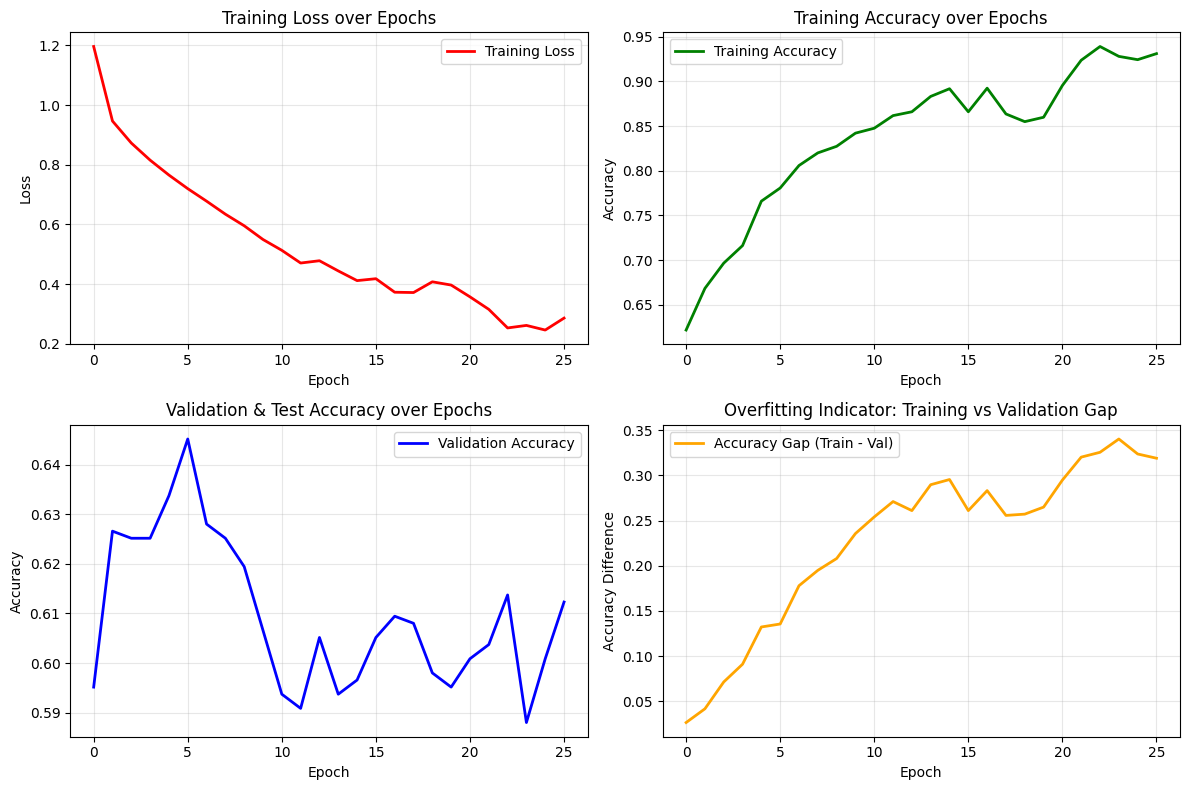

In [ ]:
plt.figure(figsize=(12, 8))

# Training Loss
plt.subplot(2, 2, 1)
plt.plot(training_metrics['train_losses'], label='Training Loss', color='red', linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.grid(True, alpha=0.3)
plt.legend()

# Training Accuracy
plt.subplot(2, 2, 2)
plt.plot(training_metrics['training_accuracies'], label='Training Accuracy', color='green', linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy over Epochs")
plt.grid(True, alpha=0.3)
plt.legend()

# Validation Accuracy
plt.subplot(2, 2, 3)
plt.plot(training_metrics['val_accuracies'], label='Validation Accuracy', color='blue', linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation & Test Accuracy over Epochs")
plt.grid(True, alpha=0.3)
plt.legend()

# Accuracy Gap
plt.subplot(2, 2, 4)
accuracy_gap = [train - val for train, val in zip(training_metrics['training_accuracies'], training_metrics['val_accuracies'])]
plt.plot(accuracy_gap, label='Accuracy Gap (Train - Val)', color='orange', linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Accuracy Difference")
plt.title("Overfitting Indicator: Training vs Validation Gap")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

### MLP with regularization

In [ ]:
EPOCHS = 1500
PATIENCE = 20
LEARNING_RATE = 0.0005

In [ ]:
mlp_reg = MLPClassifier(
    hidden_layer_sizes=(256, 128, 64, 32),
    activation='tanh',
    solver='adam',
    alpha=0.001,
    batch_size=32,
    learning_rate='constant',
    learning_rate_init=LEARNING_RATE,
    max_iter=1,
    warm_start=True,
    random_state=42,
    verbose=False
)

In [ ]:
training_metrics = {
    'train_losses': [],
    'val_accuracies': [],
    'training_accuracies': [],
    'test_accuracies': []
}

reg_mlp_metrics = {
    'training_accuracy': 0,
    'validation_accuracy': 0,
    'test_accuracy': 0,
    'training_time': 0,
    'best_epoch': 0
}

reg_best_acc = 0
no_improve = 0

In [ ]:
print("Training Regularization MLP...\n")
training_start = time.time()
progress = tqdm(range(1, EPOCHS + 1), desc="Training Progress", ncols=100)

for epoch in progress:
    mlp_reg.fit(X_train_scaled, y_train)
    y_pred_reg = mlp_reg.predict(X_test_scaled)

    val_acc = accuracy_score(y_test, y_pred_reg)
    train_loss = mlp_reg.loss_

    # Calculate training accuracy
    y_train_pred = mlp_reg.predict(X_train_scaled)
    train_acc = accuracy_score(y_train, y_train_pred)

    # Save metrics
    training_metrics['train_losses'].append(train_loss)
    training_metrics['val_accuracies'].append(val_acc)
    training_metrics['training_accuracies'].append(train_acc)
    training_metrics['test_accuracies'].append(val_acc)

    # Progress bar display
    progress.set_description(
        f"Epoch {epoch:03d} | Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}"
    )

    # Early stopping check
    if val_acc > reg_best_acc:
        reg_best_acc = val_acc
        reg_mlp_metrics['best_epoch'] = epoch
        no_improve = 0
    else:
        no_improve += 1

    if no_improve >= PATIENCE:
        print(f"\nEarly termination at epoch {epoch}, best accuracy = {reg_best_acc:.4f}")
        break

Training Regularization MLP...



Epoch 032 | Loss: 0.4054 | Val Acc: 0.6052:   2%|▎                | 31/1500 [00:11<09:24,  2.60it/s]


Early termination at epoch 32, best accuracy = 0.6438


In [ ]:
reg_mlp_metrics['training_time'] = time.time() - training_start
reg_mlp_metrics['validation_accuracy'] = reg_best_acc
reg_mlp_metrics['training_accuracy'] = training_metrics['training_accuracies'][-1]
reg_mlp_metrics['test_accuracy'] = reg_best_acc

In [ ]:
reg_mlp_metrics_df = pd.DataFrame({
    'epoch': range(1, len(training_metrics['train_losses']) + 1),
    'train_loss': training_metrics['train_losses'],
    'train_accuracy': training_metrics['training_accuracies'],
    'val_accuracy': training_metrics['val_accuracies'],
    'test_accuracy': training_metrics['test_accuracies']
})

#### Regularization MLP Metrics

In [ ]:
t = PrettyTable(["Metric", "Value"])
t.add_row(["Training Accuracy", f"{reg_mlp_metrics['training_accuracy']:.4f}"])
t.add_row(["Validation Accuracy", f"{reg_mlp_metrics['validation_accuracy']:.4f}"])
t.add_row(["Test Accuracy", f"{reg_mlp_metrics['test_accuracy']:.4f}"])
t.add_row(["Training Time", f"{reg_mlp_metrics['training_time']:.2f}s"])
t.add_row(["Best Epoch", f"{reg_mlp_metrics['best_epoch']}"])
print(t)

+---------------------+--------+
|        Metric       | Value  |
+---------------------+--------+
|  Training Accuracy  | 0.8765 |
| Validation Accuracy | 0.6438 |
|    Test Accuracy    | 0.6438 |
|    Training Time    | 11.93s |
|      Best Epoch     |   12   |
+---------------------+--------+


In [ ]:
print(f"\nTraining completed in {reg_mlp_metrics['training_time']:.2f} seconds")
print(f"Final Accuracy: {training_metrics['val_accuracies'][-1]:.4f}")
print(f"Best validation accuracy: [{reg_mlp_metrics['validation_accuracy']:.4f}] at epoch [{reg_mlp_metrics['best_epoch']}]")


Training completed in 11.93 seconds
Final Accuracy: 0.6052
Best validation accuracy: [0.6438] at epoch [12]


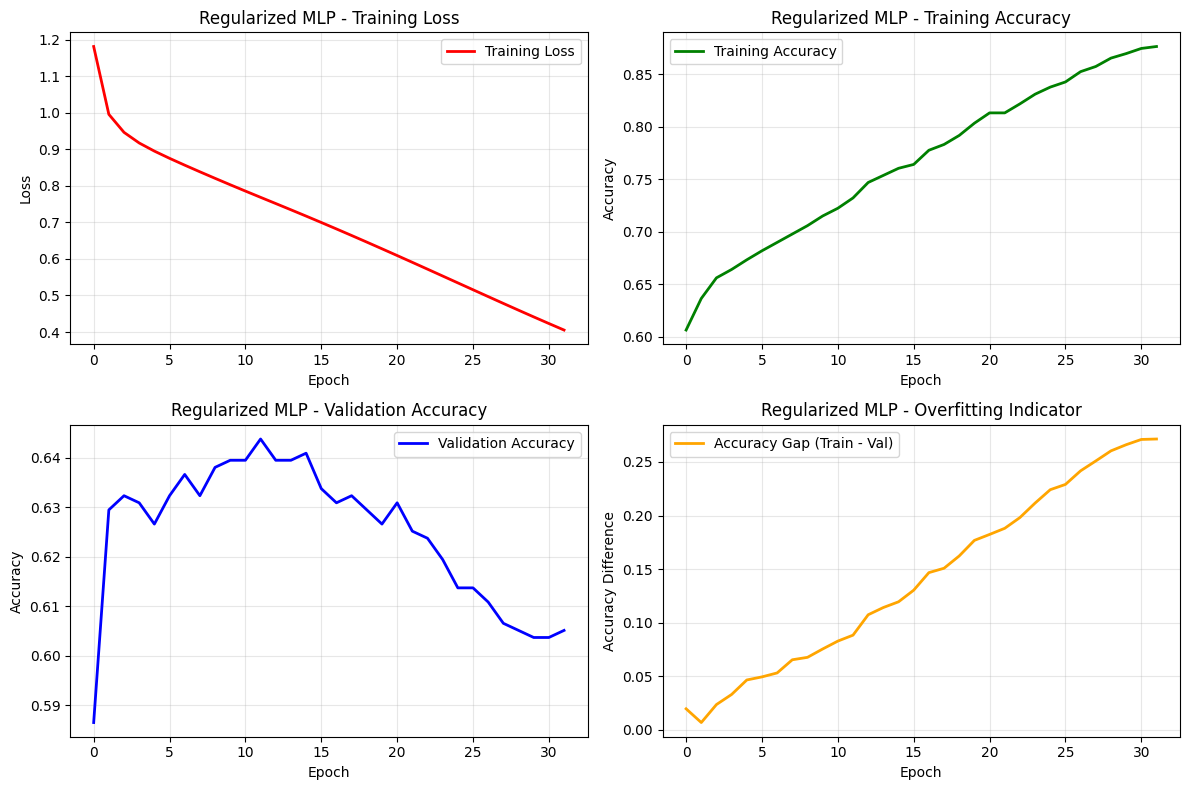

In [ ]:
plt.figure(figsize=(12, 8))

# Training Loss
plt.subplot(2, 2, 1)
plt.plot(training_metrics['train_losses'], label='Training Loss', color='red', linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Regularized MLP - Training Loss")
plt.grid(True, alpha=0.3)
plt.legend()

# Training Accuracy
plt.subplot(2, 2, 2)
plt.plot(training_metrics['training_accuracies'], label='Training Accuracy', color='green', linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Regularized MLP - Training Accuracy")
plt.grid(True, alpha=0.3)
plt.legend()

# Validation Accuracy
plt.subplot(2, 2, 3)
plt.plot(training_metrics['val_accuracies'], label='Validation Accuracy', color='blue', linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Regularized MLP - Validation Accuracy")
plt.grid(True, alpha=0.3)
plt.legend()

# Accuracy Gap (Training vs Validation)
plt.subplot(2, 2, 4)
accuracy_gap = [train - val for train, val in zip(training_metrics['training_accuracies'], training_metrics['val_accuracies'])]
plt.plot(accuracy_gap, label='Accuracy Gap (Train - Val)', color='orange', linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Accuracy Difference")
plt.title("Regularized MLP - Overfitting Indicator")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

### Aggressive GridSearch

In [ ]:
param_grid = {
    'hidden_layer_sizes': [(256, 128), (512, 256), (256, 128, 64), (512, 256, 128)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.0005, 0.0001],
    'batch_size': [32, 64, 128]
}

In [ ]:
mlp = MLPClassifier(
    solver='adam',
    max_iter=1000,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.2
)

In [ ]:
print("\nStarting GridSearch with parallel jobs...")

start_time = time.time()
grid_search = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,       # paralel parking :P
    verbose=2
)
grid_search.fit(X_train_scaled, y_train)
duration = time.time() - start_time

print(f"\nGridSearch completed in {duration/60:.1f} minutes")


Starting GridSearch with parallel jobs...
Fitting 3 folds for each of 216 candidates, totalling 648 fits

GridSearch completed in 23.4 minutes


In [ ]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_mlp = grid_search.best_estimator_

print("\nBest Parameters Found:")
for k, v in best_params.items():
    print(f"  {k}: {v}")
print(f"Best CV Accuracy: {best_score:.4f}")


Best Parameters Found:
  activation: tanh
  alpha: 0.01
  batch_size: 32
  hidden_layer_sizes: (256, 128, 64)
  learning_rate_init: 0.001
Best CV Accuracy: 0.6321


In [ ]:
results_df = pd.DataFrame(grid_search.cv_results_)

# Flatten parameters for plotting
for key in param_grid.keys():
    results_df[key] = results_df['param_' + key]

#### Aggressive Grid Search Metrics

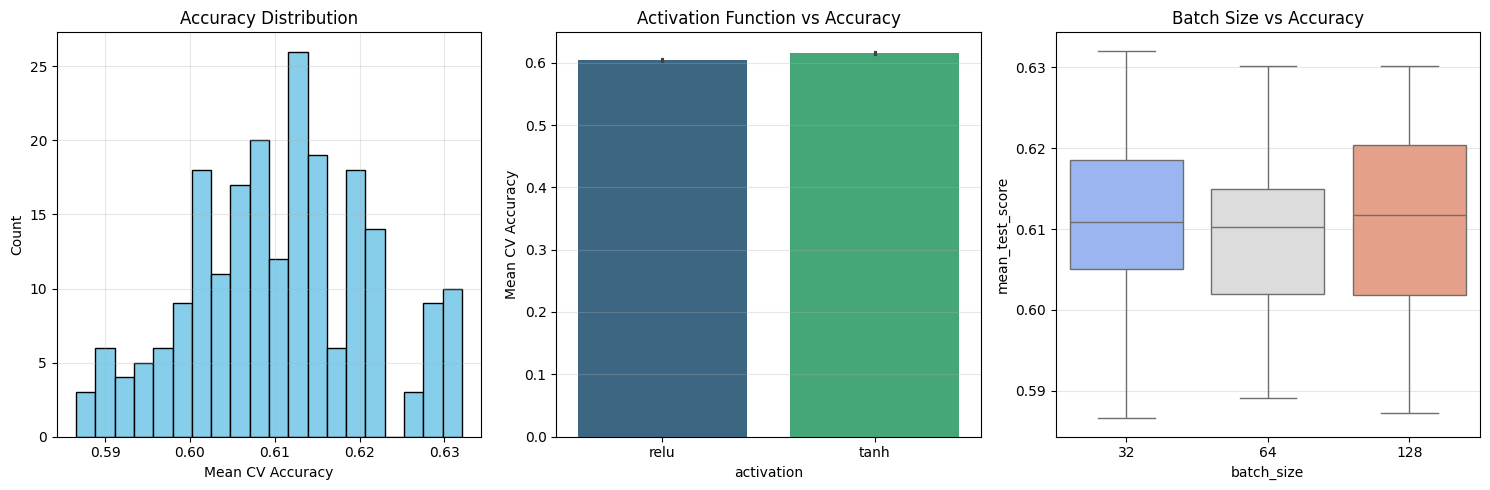

In [ ]:
plt.figure(figsize=(15, 5))

# Accuracy Distribution
plt.subplot(1, 3, 1)
plt.hist(results_df['mean_test_score'], bins=20, color='skyblue', edgecolor='black')
plt.title("Accuracy Distribution")
plt.xlabel("Mean CV Accuracy")
plt.ylabel("Count")
plt.grid(True, alpha=0.3)

# Activation Comparison
plt.subplot(1, 3, 2)
sns.barplot(x='activation', y='mean_test_score', data=results_df, palette='viridis')
plt.title("Activation Function vs Accuracy")
plt.ylabel("Mean CV Accuracy")
plt.grid(axis='y', alpha=0.3)

# Batch Size Impact
plt.subplot(1, 3, 3)
sns.boxplot(x='batch_size', y='mean_test_score', data=results_df, palette='coolwarm')
plt.title("Batch Size vs Accuracy")
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

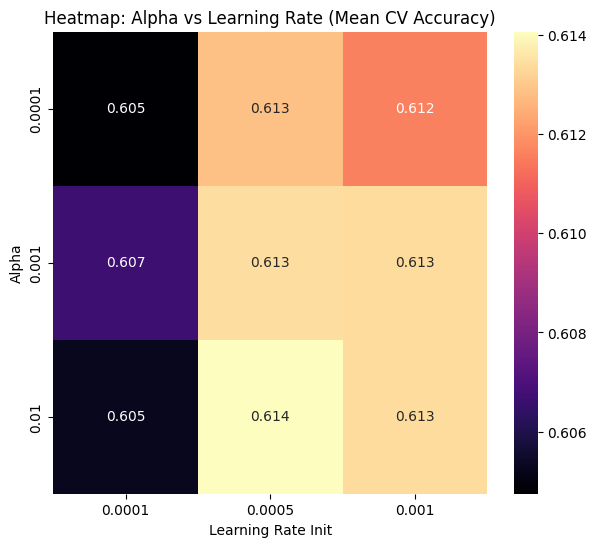

In [ ]:
plt.figure(figsize=(7, 6))
pivot_heat = results_df.pivot_table(
    values='mean_test_score',
    index='alpha',
    columns='learning_rate_init',
    aggfunc='mean'
)

sns.heatmap(pivot_heat, annot=True, cmap='magma', fmt=".3f")
plt.title("Heatmap: Alpha vs Learning Rate (Mean CV Accuracy)")
plt.xlabel("Learning Rate Init")
plt.ylabel("Alpha")
plt.show()


In [ ]:
# Retrain the Best Model
print("\nRetraining best model for learning curve")
best_mlp.fit(X_train_scaled, y_train)

test_acc = best_mlp.score(X_test_scaled, y_test)
print(f"Retrained best model | Test Accuracy: {test_acc:.4f}")


Retraining best model for learning curve
Retrained best model | Test Accuracy: 0.6223


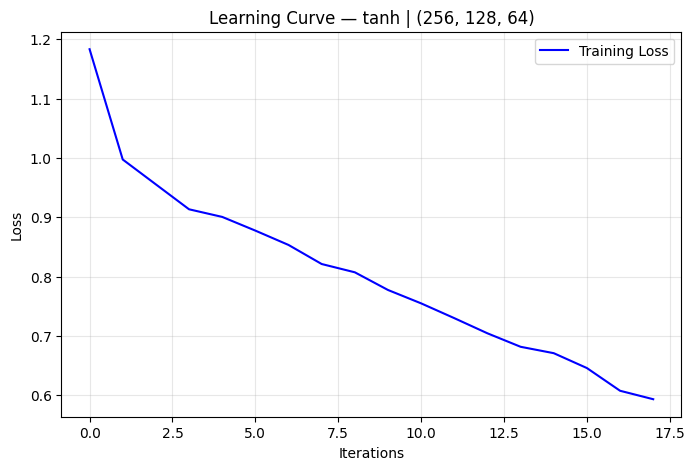

In [ ]:
# Learning Curve Plot
plt.figure(figsize=(8, 5))
plt.plot(best_mlp.loss_curve_, color='blue', label='Training Loss')
plt.title(f"Learning Curve — {best_params['activation']} | {best_params['hidden_layer_sizes']}")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Time intensive, save it
joblib.dump(best_mlp, "best_grid_mlp_model.pkl")
print("\nSaved best model as 'best_grid_mlp_model.pkl'")


Saved best model as 'best_grid_mlp_model.pkl'


### MLP Ensemble

In [ ]:
class MLPEnsemble:
    def __init__(self, n_estimators=5):
        self.n_estimators = n_estimators
        self.models = []

    def fit(self, X, y):
        self.models = []
        for i in range(self.n_estimators):
            mlp = MLPClassifier(
                hidden_layer_sizes=(256, 128),
                activation='relu',
                solver='adam',
                alpha=0.001,
                random_state=42 + i,  # Different random state for each
                max_iter=800,
                early_stopping=True
            )
            print(f"Training ensemble member {i+1}/{self.n_estimators}...")
            mlp.fit(X, y)
            self.models.append(mlp)

    def predict(self, X):
        predictions = np.zeros((X.shape[0], len(self.models)))
        for i, model in enumerate(self.models):
            predictions[:, i] = model.predict(X)
        # Majority voting
        return np.array([np.bincount(predictions[i].astype(int)).argmax()
                        for i in range(predictions.shape[0])])

In [ ]:
ensemble = MLPEnsemble(n_estimators=5)
ensemble.fit(X_train_scaled, y_train)

y_pred_ensemble = ensemble.predict(X_test_scaled)
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)

Training ensemble member 1/5...
Training ensemble member 2/5...
Training ensemble member 3/5...
Training ensemble member 4/5...
Training ensemble member 5/5...


In [ ]:
print(f"Ensemble MLP Accuracy: {accuracy_ensemble:.4f}")

Ensemble MLP Accuracy: 0.6381


#### Ensemble MLP Metrics

In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred_ensemble))

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.47      0.52        99
           1       0.60      0.70      0.65       150
           2       0.61      0.60      0.61       150
           3       0.59      0.67      0.63       150
           4       0.82      0.69      0.75       150

    accuracy                           0.64       699
   macro avg       0.64      0.63      0.63       699
weighted avg       0.65      0.64      0.64       699



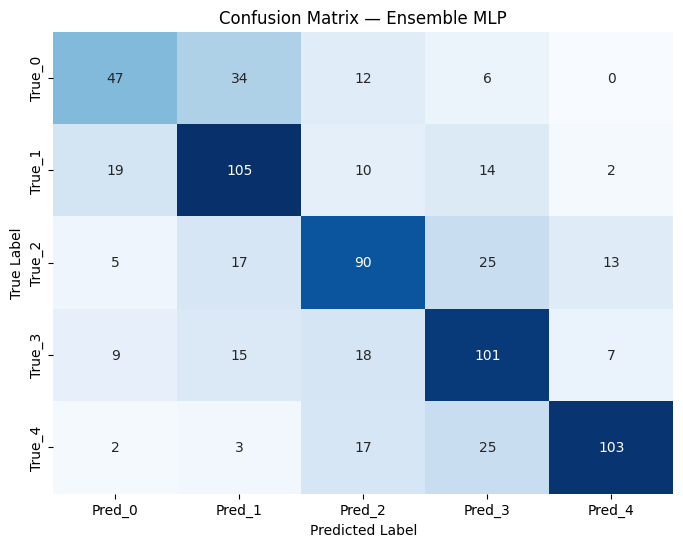

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_ensemble)
cm_df = pd.DataFrame(
    cm,
    index=[f"True_{cls}" for cls in np.unique(y_test)],
    columns=[f"Pred_{cls}" for cls in np.unique(y_test)]
)

#Confusion Matrix Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix — Ensemble MLP")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

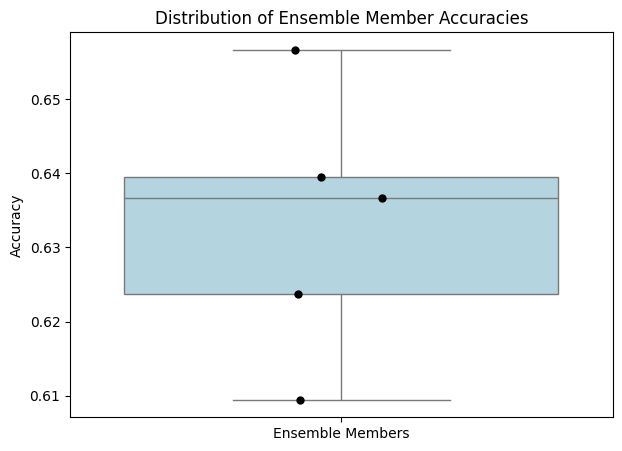

In [ ]:
# Ensemble Members' Accuracy
member_accuracies = []
for i, model in enumerate(ensemble.models):
    preds = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, preds)
    member_accuracies.append(acc)

plt.figure(figsize=(7,5))
sns.boxplot(data=member_accuracies, color='lightblue')
sns.stripplot(data=member_accuracies, color='black', size=6, jitter=True)
plt.title("Distribution of Ensemble Member Accuracies")
plt.ylabel("Accuracy")
plt.xticks([0], ["Ensemble Members"])
plt.show()

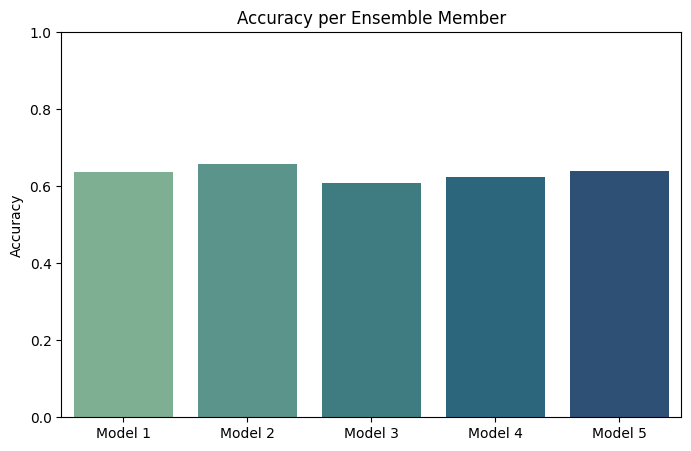

In [ ]:
# Individual Member Accuracies
plt.figure(figsize=(8,5))
sns.barplot(x=[f"Model {i+1}" for i in range(len(ensemble.models))],
            y=member_accuracies, palette="crest")
plt.title("Accuracy per Ensemble Member")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()

### Compare with Random Forest

In [ ]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
y_proba_rf = rf.predict_proba(X_test_scaled)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(f"Random Forest Accuracy: {accuracy_rf:.4f}")

Random Forest Accuracy: 0.6438


In [ ]:
# Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

#### Random Forest Metrics

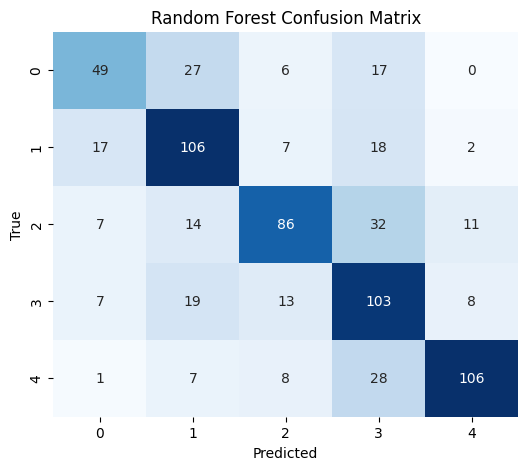

In [ ]:
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


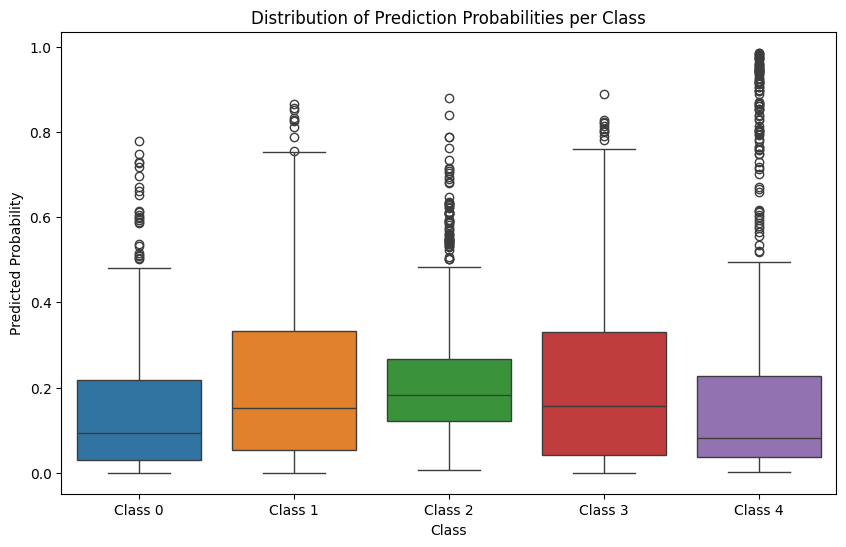

In [ ]:
if y_proba_rf.shape[1] <= 10:
    proba_df = pd.DataFrame(y_proba_rf, columns=[f"Class {i}" for i in range(y_proba_rf.shape[1])])
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=proba_df)
    plt.title("Distribution of Prediction Probabilities per Class")
    plt.xlabel("Class")
    plt.ylabel("Predicted Probability")
    plt.show()
else:
    print("Skipping probability boxplot (too many classes).")

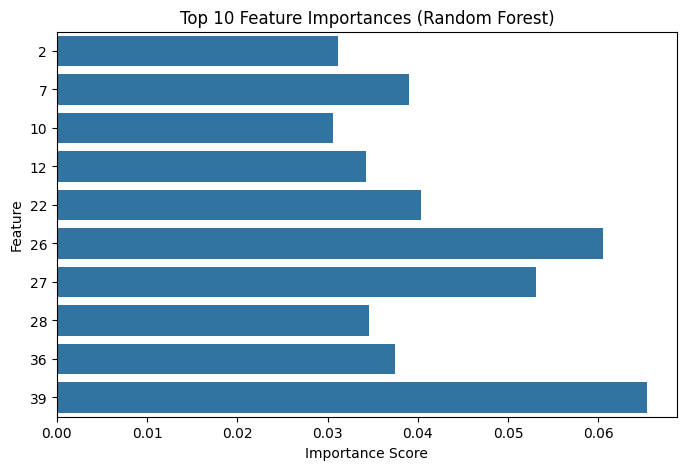

In [ ]:
importances = rf.feature_importances_
indices = np.argsort(importances)[-10:][::-1]  # top 10 important features

plt.figure(figsize=(8, 5))
sns.barplot(
    x=importances[indices],
    y=np.array(X_train.columns)[indices] if hasattr(X_train, 'columns') else indices,
    orient='h'
)
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


## Result Comparison

In [ ]:
results = {
    'Model': ['Base MLP', 'Regularization MLP', 'Gridsearch MLP', 'MLP Ensemble', 'Random Forest'],
    'Accuracy': [base_best_acc, reg_best_acc, best_score, accuracy_ensemble, accuracy_rf]
}

results_df = pd.DataFrame(results)
print(results_df)


                Model  Accuracy
0            Base MLP  0.645207
1  Regularization MLP  0.643777
2      Gridsearch MLP  0.632067
3        MLP Ensemble  0.638054
4       Random Forest  0.643777


In [ ]:
best_idx = results_df['Accuracy'].idxmax()
best_model_name = results_df.loc[best_idx, 'Model']
best_accuracy = results_df.loc[best_idx, 'Accuracy']

print(f"\nAccurate Model: {best_model_name} with {best_accuracy:.4f} accuracy")



Accurate Model: Base MLP with 0.6452 accuracy


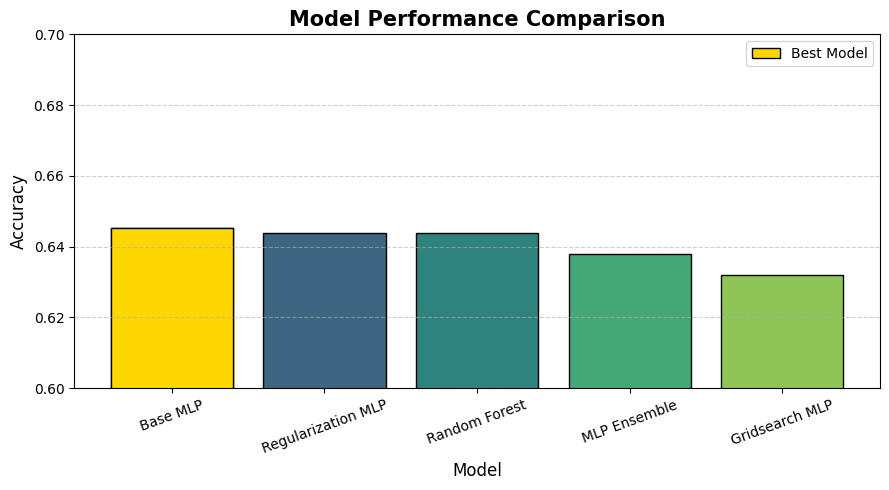

In [ ]:
results_df = pd.DataFrame(results)

# Sort by accuracy
results_df = results_df.sort_values(by='Accuracy', ascending=False)

plt.figure(figsize=(9, 5))
sns.barplot(
    data=results_df,
    x='Model', y='Accuracy',
    palette='viridis', edgecolor='black'
)

# Highlight best model
best_model = results_df.iloc[0]
plt.bar(
    best_model['Model'], best_model['Accuracy'],
    color='gold', edgecolor='black', label='Best Model'
)

# Labels and style
plt.title('Model Performance Comparison', fontsize=15, weight='bold')
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0.6, 0.7)
plt.xticks(rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

### Best model metrics

Classification Report:
              precision    recall  f1-score   support

       akiec       0.59      0.41      0.49        99
         bcc       0.64      0.69      0.66       150
         bkl       0.58      0.61      0.59       150
         mel       0.52      0.69      0.59       150
          nv       0.86      0.64      0.73       150

    accuracy                           0.62       699
   macro avg       0.64      0.61      0.61       699
weighted avg       0.64      0.62      0.62       699



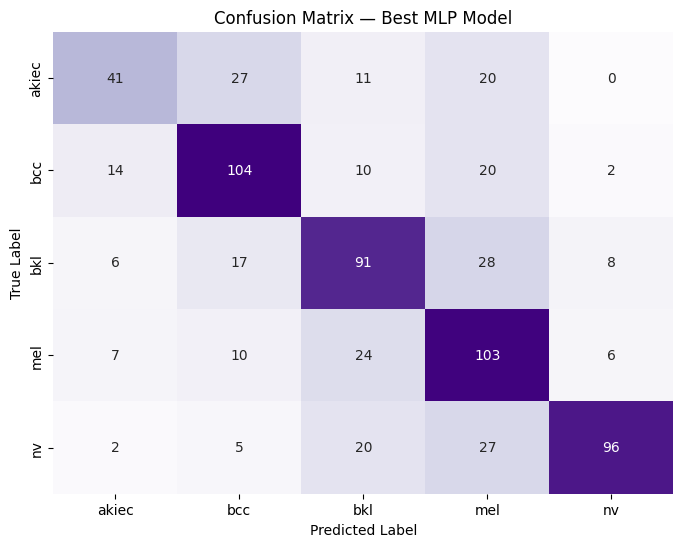

In [ ]:
if best_accuracy >= best_score:
    best_model_for_analysis = best_mlp
else:
    best_model_for_analysis = mlp_base

# Predictions
y_pred_final = best_model_for_analysis.predict(X_test_scaled)

# Encode labels
le = LabelEncoder()
le.fit(labels)
class_names = le.classes_

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_final, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Purples', cbar=False)
plt.title("Confusion Matrix — Best MLP Model")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


Feature Importance Analysis:
Top 10 most important features: [26 36  4  0 22 14 18  7 27 39]


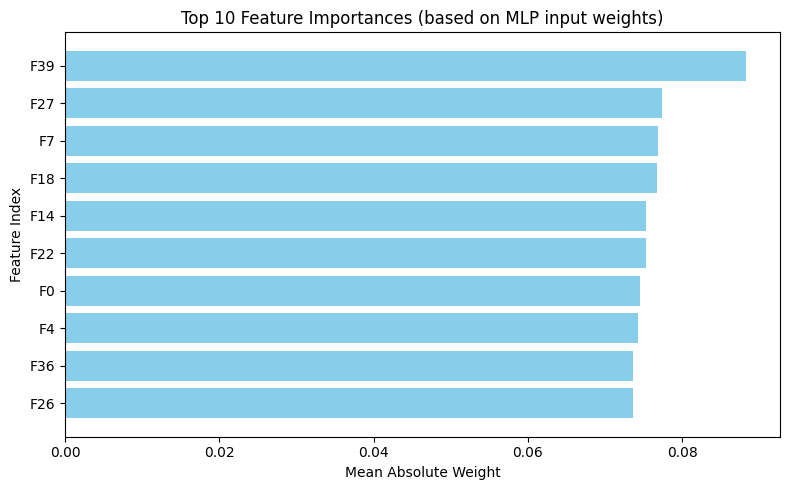

In [ ]:
if hasattr(best_model_for_analysis, 'coefs_'):
    print(f"\nFeature Importance Analysis:")
    input_weights = np.mean(np.abs(best_model_for_analysis.coefs_[0]), axis=1)
    top_features = np.argsort(input_weights)[-10:]
    print(f"Top 10 most important features: {top_features}")

    # visualize feature importance
    plt.figure(figsize=(8,5))
    plt.barh(range(len(top_features)), input_weights[top_features], color='skyblue')
    plt.yticks(range(len(top_features)), [f"F{i}" for i in top_features])
    plt.title("Top 10 Feature Importances (based on MLP input weights)")
    plt.xlabel("Mean Absolute Weight")
    plt.ylabel("Feature Index")
    plt.tight_layout()
    plt.show()